In [1]:
import os
from random import seed, sample
import numpy as np
import cv2
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras import layers, models
from keras.optimizers import SGD, Adam
from keras. callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
batch_size = 64
epochs = 120
amount = 5 #for each category

In [3]:
path1 = 'E:\\deeplearning\\Hepatocarcinomes\\models\\5x\\test_dataAmount\\0k_010' #amount of training samples
path = 'E:\\deeplearning\\Hepatocarcinomes\\data\\5x\\training\\split64_image'

In [4]:
lpos_ = []
for root, dirs, files in os.walk(path+'\\pos_nor_5k' , topdown=True):
    for f in files:
        if f.endswith('.tif'):
            lpos_.append(root+'\\'+f)
seed(1)
lpos = sample(lpos_, amount)
lpos_train = lpos[0:int(amount*0.8)]
lpos_val = lpos[int(amount*0.8):amount]

In [5]:
lneg_ = []
for root, dirs, files in os.walk(path+'\\neg_tum_5k' , topdown=True):
    for f in files:
        if f.endswith('.tif'):
            lneg_.append(root+'\\'+f)
seed(1)
lneg = sample(lneg_, amount)
lneg_train = lneg[0:int(amount*0.8)]
lneg_val = lneg[int(amount*0.8):amount]

In [6]:
ltrain = lpos_train + lneg_train
lval = lpos_val + lneg_val
np.random.seed(1) 
np.random.shuffle(ltrain)
np.random.shuffle(lval)

In [7]:
img_train = np.ndarray((int(amount*1.6), 64, 64, 3))
for i in range(int(amount*1.6)):
    img_train[i, :, :, :] = cv2.cvtColor(cv2.imread(ltrain[i], -1), cv2.COLOR_BGR2RGB)/255

In [8]:
img_val = np.ndarray((int(amount*0.4), 64, 64, 3))
for i in range(int(amount*0.4)):
    img_val[i, :, :, :] =cv2.cvtColor(cv2.imread(lval[i], -1), cv2.COLOR_BGR2RGB)/255

In [9]:
y_train = np.vstack((np.ones(int(amount*0.8), np.float32), np.zeros(int(amount*0.8), np.float32)))
y_val = np.vstack((np.ones(int(amount*0.2), np.float32), np.zeros(int(amount*0.2), np.float32)))

y_train = y_train.reshape(-1,1)
y_val = y_val.reshape(-1,1)

np.random.seed(1) 
np.random.shuffle(y_train)
np.random.shuffle(y_val)

y_train = to_categorical(y_train, 2)
y_val = to_categorical(y_val, 2)

In [30]:
base_model = VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(64,64,3), pooling=None)

In [31]:
x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(4096, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(2, activation = 'softmax')(x)

In [32]:
model = models.Model(input=base_model.input, output=predictions)

C:\Program Files\Anaconda3\envs\r-tensorflow\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if __name__ == '__main__':


In [33]:
# model.summary()

In [34]:
# model.compile(optimizer = SGD(lr = 1e-2, decay=0.001, momentum=0.9), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [35]:
model.compile(optimizer = Adam(lr = 1e-3), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [36]:
csv_logger = CSVLogger(path1+'\\3_adam_64_lr3_training.csv', append=True)
model_checkpoint = ModelCheckpoint(path1+'\\3_adam_64_lr3_weights.{epoch:02d}-{val_acc:.4f}.hdf5', monitor='val_loss',verbose=1, save_best_only=True, period=15)
early_stop = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=15, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, min_delta=0.005, cooldown=3, patience=8, verbose=1)
results = model.fit(img_train, y_train, batch_size, epochs=100, verbose=1, callbacks=[csv_logger, model_checkpoint, early_stop, reduce_lr], validation_data=(img_val, y_val))
csv_logger.csv_file.close()

Train on 8 samples, validate on 2 samples
Epoch 1/100
8/8 [==============================] - 7s 849ms/step - loss: 1.7774 - acc: 0.2500 - val_loss: 4.0634 - val_acc: 0.5000
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 0.9024 - acc: 0.5000 - val_loss: 5.9410 - val_acc: 0.5000
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 0.3874 - acc: 0.8750 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 0.1274 - acc: 1.0000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0462 - acc: 1.0000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 6/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0188 - acc: 1.0000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 7/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0029 - acc: 1.0000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 8/100
8/8 [==============================

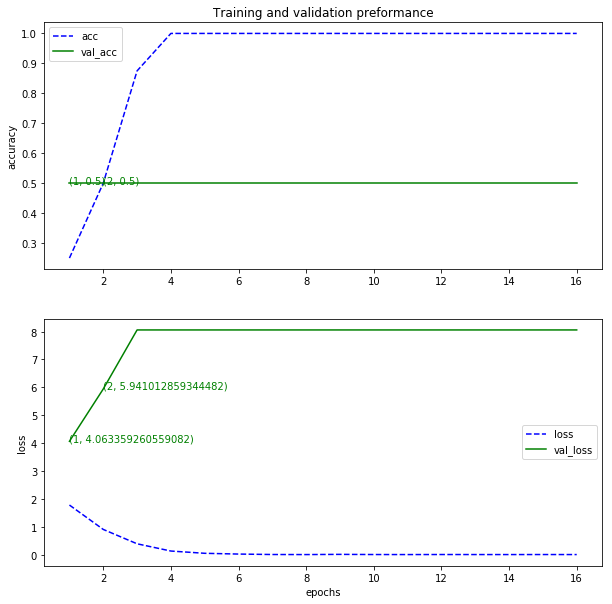

In [37]:
#plot training results
acc=results.history['acc']
val_acc=results.history['val_acc']
loss=results.history['loss']
val_loss=results.history['val_loss']

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.ylabel('accuracy')
# plt.ylim((0, 5))

epochs=range(1, len(acc)+1)
plt.plot(epochs,acc,'b--',label='acc')
plt.plot(epochs, val_acc,'g',label='val_acc')
index0=np.where(val_acc==np.amax(val_acc))[0]
if(len(index0)>3):
    for i in range(2):
        plt.text(epochs[int(i)], val_acc[int(i)], str((epochs[int(i)], val_acc[int(i)])),color='g')
else:
    for i in index0:
        plt.text(epochs[int(i)], val_acc[int(i)], str((epochs[int(i)], val_acc[int(i)])),color='g')
    
plt.title('Training and validation preformance')
plt.legend()

plt.subplot(2,1,2)
plt.xlabel('epochs')
plt.ylabel('loss')
# plt.ylim((0, 5))

epochs=range(1, len(loss)+1)
plt.plot(epochs,loss,'b--',label='loss')
plt.plot(epochs, val_loss,'g',label='val_loss')
if(len(index0)>3):
    for i in range(2):
        plt.text(epochs[int(i)], val_loss[int(i)], str((epochs[int(i)], val_loss[int(i)])),color='g')
else:
    for i in index0:
        plt.text(epochs[int(i)], val_loss[int(i)], str((epochs[int(i)], val_loss[int(i)])),color='g')
    
plt.legend()
plt.savefig(path1+'\\3_adam_64_lr4_training_validation_performance')
plt.show()

In [38]:
model.save(path1 + '\\3_adam_64_lr3_best_model.hdf5')

In [39]:
del(model)

####best parameters:
50k: batch_size=128, optimizer=Adam (lr=3)
